<font size = 4>**COSC-576 Assignment1** </font>  
<font size = 3>**Yingxuan Li**</font>

<font size = 3>**Question1 Feed Forward Neural Network**</font>

In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

NN(
  (linear0): Linear(in_features=1, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out0): Linear(in_features=100, out_features=1, bias=True)
  (out1): Linear(in_features=100, out_features=1, bias=True)
  (non_linear): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000 train =     5000	  0.0206   0.0040	dev =      101	  0.0042   0.0003
epoch =     1    10003 train =     5003	  0.0010   0.0001	dev =      101	  0.0002   0.0000
epoch =     2    15006 train =     5003	  0.0001   0.0000	dev =      101	  0.0001   0.0000
epoch =     3    20009 train =     5003	  0.0001   0.0000	dev =      101	  0.0001   0.0001
epoch =     4    25002 train =     4993	  0.0001   0.0000	dev =      101	  0.0002   0.0001
epoch =     5    30005 train =     5003	  0.0001   0.0000	dev =      101	  0.0001   0.0000
epoch =     6    35008 train =     5003	  0.0001   0.0000	dev =      101	  0.0000   0.0000
epoch =     7  

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


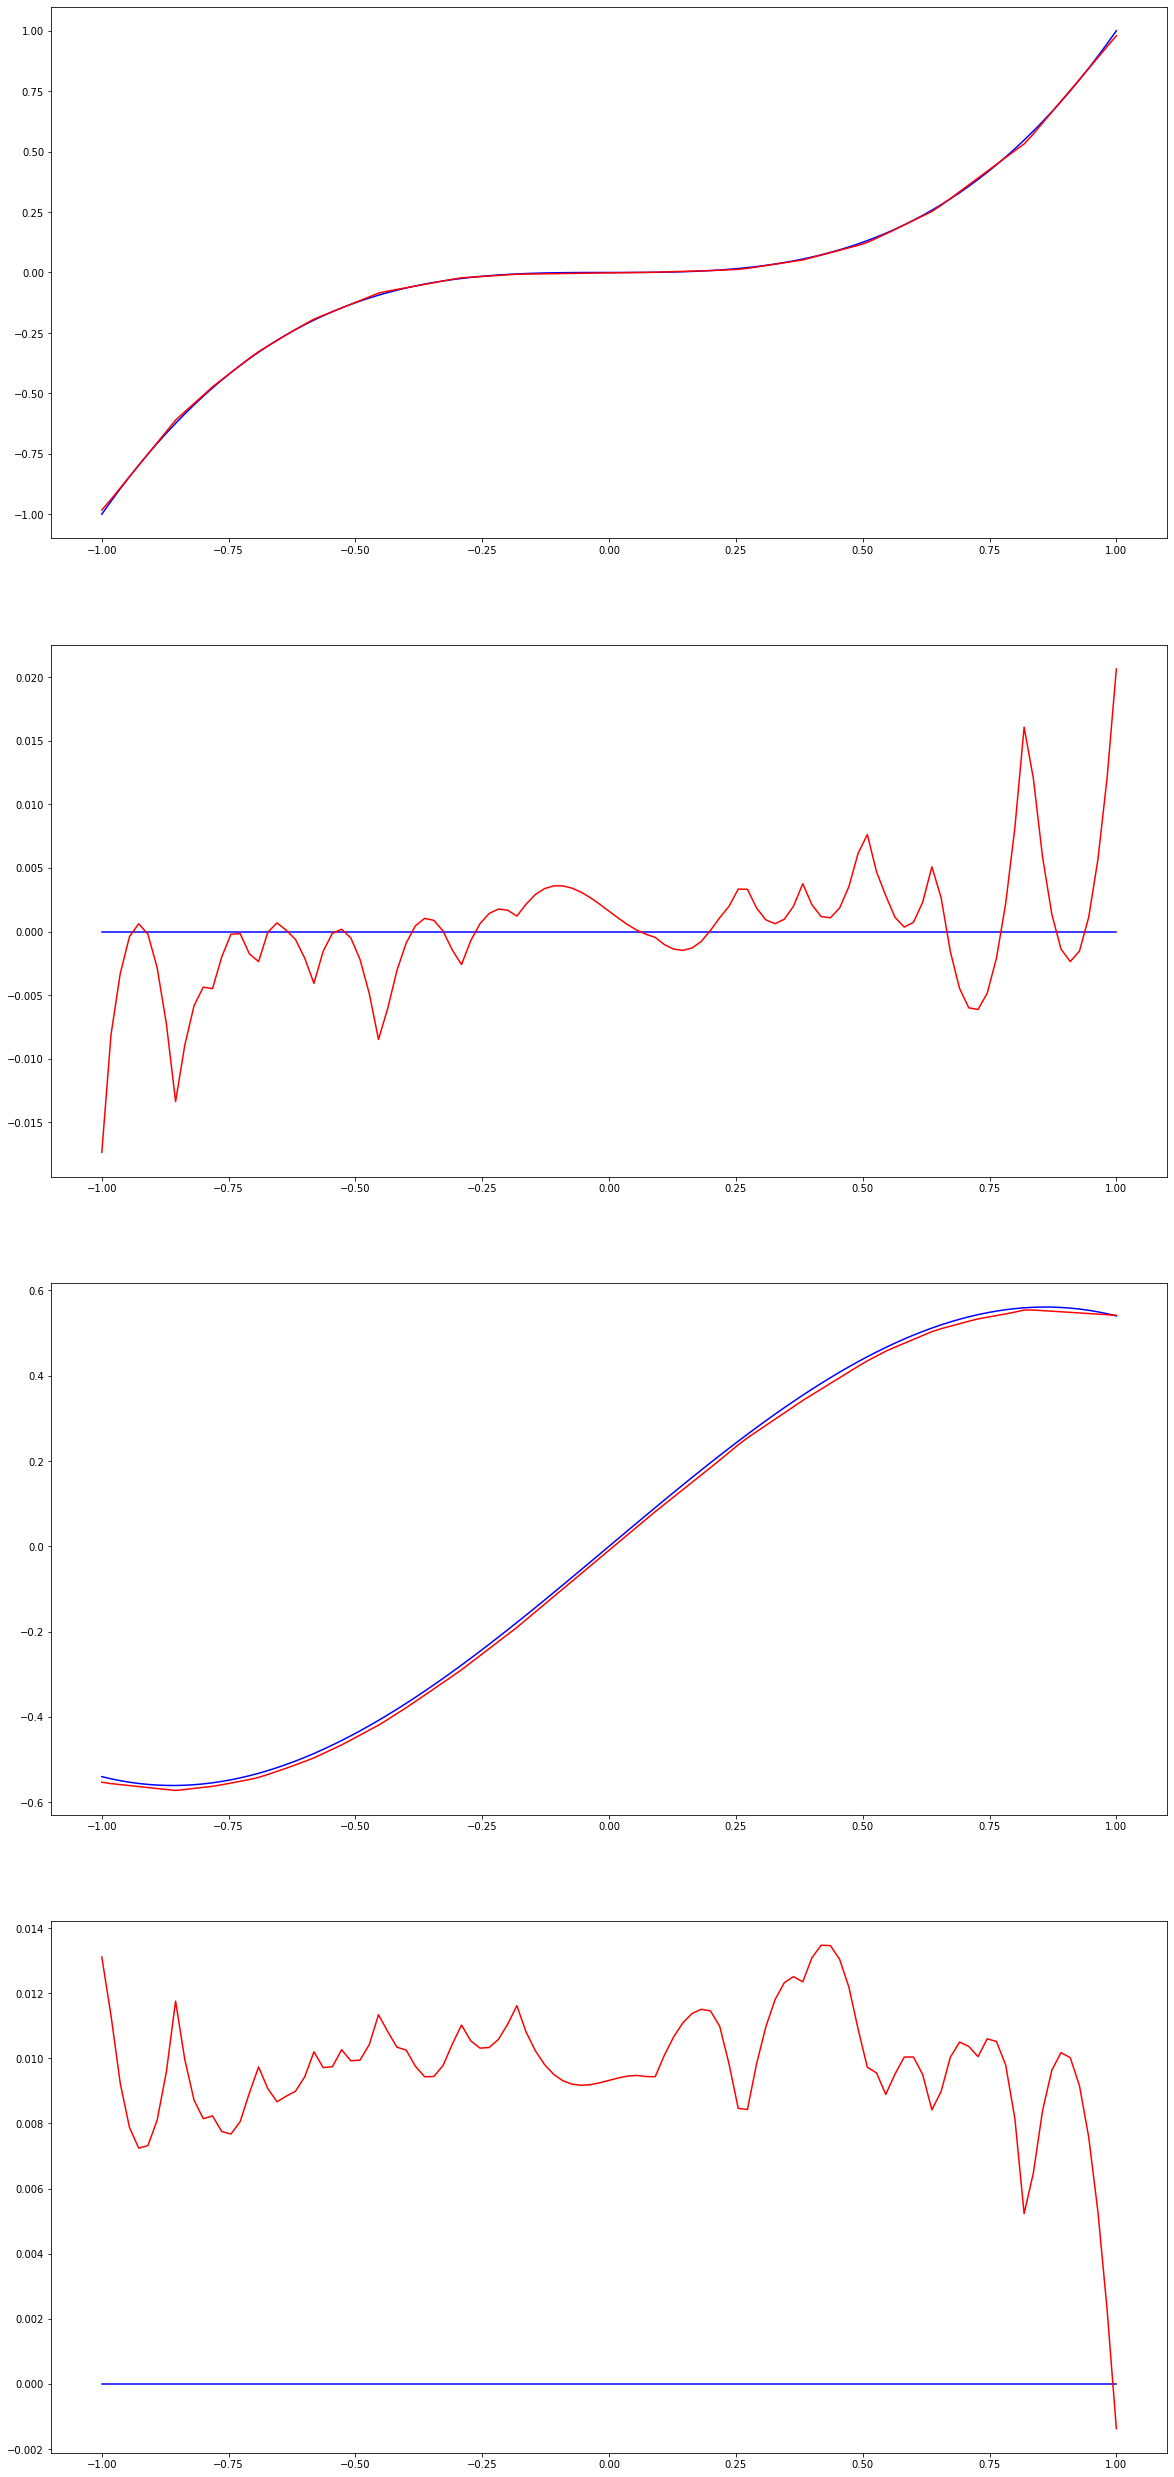

In [2]:
###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

#learning_rate = 0.0001
learning_rate = 0.001
#learning_rate = 0.01
#learning_rate = 0.1

# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0
#dropout = 0.1

L2_lambda = 0.0
#L2_lambda = 0.1

#batch_size = 100
batch_size = 10
#batch_size = 1

# control amount of training data
nTrainPoints = 10
#nTrainPoints = 19
#nTrainPoints = 1009
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 111

#DesiredTrainSamples = 5000
DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out0 = nn.Linear(nLinear2, 1)    # output for func0
        self.out1 = nn.Linear(nLinear2, 1)    # output for func1


        self.non_linear = nn.LeakyReLU(negative_slope=0.01, inplace=False)

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

    ###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        out0 = self.out0(x)  # func0
        out1 = self.out1(x)  # func1

        return out0, out1

###############################################################################
def train(model, optimizer, criteria, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets0 = []
    targets1 = []
    loss0 = 0
    loss1 = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets0.append(data[1][i])
        targets1.append(data[2][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs  = torch.Tensor(inputs)
    targets0 = torch.Tensor(targets0)
    targets1 = torch.Tensor(targets1)

    if use_cuda:
        inputs = inputs.cuda()
        targets0 = targets0.cuda()
        targets1 = targets1.cuda()

    output0, output1 = model(inputs)     # "model()" invokes "model.forward()"

    loss0 += criteria[0](output0.view(-1), targets0)
    loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss = loss0 + loss1
        loss.backward()
        optimizer.step()

    return loss0.item(), loss1.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    criterion0 = nn.MSELoss(reduction='sum')
    criterion1 = nn.MSELoss(reduction='sum')
    criteria = [criterion0, criterion1]

    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

    ###############################################################################
    # train model 
    ###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss0 = 0
    TrainLoss1 = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss0, loss1, nPoints = train(model, optimizer, criteria, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss0 += loss0
            TrainLoss1 += loss1
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss0, DevLoss1, DevPoints = train(model, optimizer, criteria, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d train = %8d\t%8.4f %8.4f\tdev = %8d\t%8.4f %8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss0 / TrainPoints, TrainLoss1 / TrainPoints, DevPoints, DevLoss0 / DevPoints, DevLoss1 / DevPoints))

                TrainLoss0 = 0
                TrainLoss1 = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'mse_02-temp.pth')

    return

###############################################################################
def func0(x):
    y = x*x*x
    return y

###############################################################################
def func1(x):
    y = x*np.cos(x)
    return y

###############################################################################
def create_data(data_spec):
    x_lower, x_upper, nPoints = data_spec
    x = np.linspace(x_lower, x_upper, num=nPoints, endpoint=True).astype(np.float32)
    y0 = func0(x)
    y1 = func1(x)
    return [x, y0, y1]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    lower_bound = -1
    upper_bound = +1

    train_data  = create_data([lower_bound, upper_bound, nTrainPoints])
    dev_data    = create_data([lower_bound, upper_bound, nDevPoints])
    test_data   = create_data([lower_bound, upper_bound, nTestPoints])

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(1, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y0, y1 = test_data
        out0, out1 = model(torch.Tensor(x))
        #print(out0)
        out0 = out0.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
        out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        mse0 = (((y0 - out0)**2).sum()) / len(y0)
        print("mean squared error for test data =", mse0)

        nPlots = 4
        fig = plt.figure(figsize=(20,45))

        plt.subplot(nPlots,1,1)
        plt.plot(x, y0, 'b')
        plt.plot(x, out0, 'r')

        plt.subplot(nPlots,1,2)
        plt.plot(x, y0-y0, 'b')
        plt.plot(x, y0-out0, 'r')
        #plt.plot(train_data[0], train_data[1]-train_data[1], 'o')

        plt.subplot(nPlots,1,3)
        plt.plot(x, y1, 'b')
        plt.plot(x, out1, 'r')

        plt.subplot(nPlots,1,4)
        plt.plot(x, y1-y1, 'b')
        plt.plot(x, y1-out1, 'r')
        #plt.plot(train_data[0], train_data[2]-train_data[2], 'o')

        plt.show()

<font size = 3>**Question2 Grdient Descent**  </font>  
**1) What are the partial derivatives of f(x, y) with respect to x and y?**

$$\dfrac{\partial f(x, y)}{\partial x}=12x^3-12xy-8y^2+8x  $$

$$\dfrac{\partial f(x, y)}{\partial y}=-6x^2+6y+16y^3-16xy $$

**2) Implement a gradient descent algorithm to find the minimum of this function.**

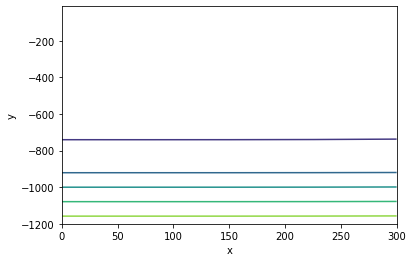

In [123]:
x, y = np.meshgrid(np.linspace(0, 300, 5), np.linspace(-12, -1200, 5))
z = 3*(x**2 - y)**2 + 4*(y**2-x)**2
plt.subplot()
plt.contour(x, y, z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


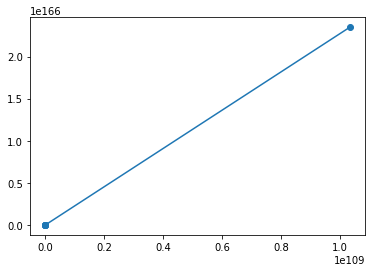

In [132]:
def grad(vec):
    x, y = vec
    dx = 12*x**3 - 12*x*y - 8*y**2 + 8*x
    dy = -6*x**2 + 6*y +16*y**3 - 16*x*y
    return np.array([dx, dy])

def grad_dec(start, iteration, alpha):
    loc = start
    traj = [loc]
    for i in range(iteration):
        g = grad(loc)
        loc = loc - alpha*g
        traj.append(loc)
    return np.array(traj)

start = np.array([300, -1200])
alpha = 0.000001
traj = grad_dec(start, 1000, alpha)
fig, ax = plt.subplots()
pic = ax.contour(x, y, z)
X = traj[: , 0]
Y = traj[: , 1]
plt.plot(X, Y, '-o')

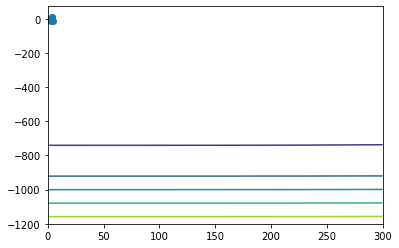

In [125]:
start = np.array([3, -12])
alpha = 0.00088
traj = grad_dec(start, 1000, alpha)
fig, ax = plt.subplots()
pic = ax.contour(x, y, z)
X = traj[: , 0]
Y = traj[: , 1]
plt.plot(X, Y, '-o')

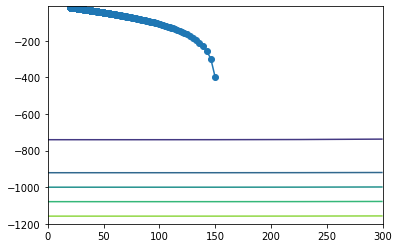

In [131]:
start = np.array([150, -400])
alpha = 0.0000001
traj = grad_dec(start, 1000, alpha)
fig, ax = plt.subplots()
pic = ax.contour(x, y, z)
X = traj[: , 0]
Y = traj[: , 1]
plt.plot(X, Y, '-o')

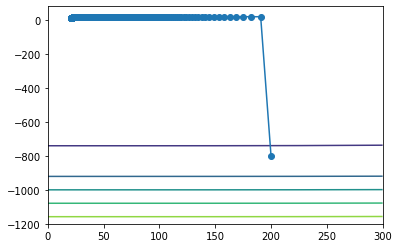

In [142]:
start = np.array([200, -800])
alpha = 0.0000001
traj = grad_dec(start, 1000, alpha)
fig, ax = plt.subplots()
pic = ax.contour(x, y, z)
X = traj[: , 0]
Y = traj[: , 1]
plt.plot(X, Y, '-o')

**3) Add at least one improvement to your algorithm which increases convergence or robustness.**  
From the picture above we could find that we can get the mininum of this function at point(0,0) with most of the strating values. However, for starting point(300, -1200),we cannot get the mininum. To increase the convergence of this algorithm, we can adjust the value of alpha to improve the result.

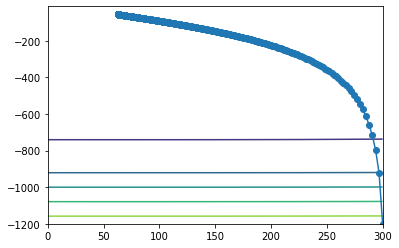

In [134]:
start = np.array([300, -1200])
alpha = 0.00000001
traj = grad_dec(start, 1000, alpha)
fig, ax = plt.subplots()
pic = ax.contour(x, y, z)
X = traj[: , 0]
Y = traj[: , 1]
plt.plot(X, Y, '-o')

<font size = 3>**Question3 Build an XOR Neural Net using PyTorch**</font>

NN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (non_linear): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000	 train =     5000	  0.1093	dev =      101	  0.0573
epoch =     1    10003	 train =     5003	  0.0585	dev =      101	  0.0351
epoch =     2    15006	 train =     5003	  0.0421	dev =      101	  0.0262
epoch =     3    20009	 train =     5003	  0.0332	dev =      101	  0.0275
epoch =     4    25002	 train =     4993	  0.0299	dev =      101	  0.0211
epoch =     5    30005	 train =     5003	  0.0273	dev =      101	  0.0144
epoch =     6    35008	 train =     5003	  0.0237	dev =      101	  0.0114
epoch =     7    40001	 train =     4993	  0.0211	dev =      101	  0.0096
epoch =     8    45004	 train =     5003	  0.0193	dev =      101	  0.0094
epoch =     9    50007	 train =     5003	  0.018

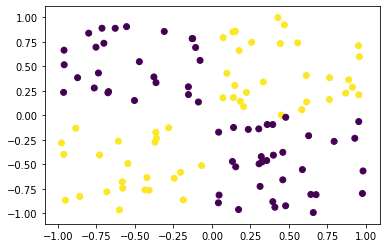

Test results:


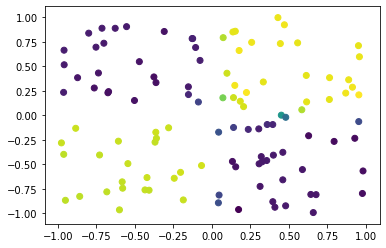

In [3]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

learning_rate = 0.001


# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0

L2_lambda = 0.0

batch_size = 10

# control amount of training data
nTrainPoints = 10
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 111

DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out = nn.Linear(nLinear2, 1)    # output 

        self.non_linear = nn.LeakyReLU(negative_slope=0.01, inplace=False)

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        out = self.out(x)  

        return out

###############################################################################
def train(model, optimizer, criterion, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)     # "model()" invokes "model.forward()"
    outputs = outputs.view(-1)
    loss += criterion(outputs, targets)
  #   loss += criteria[0](output0.view(-1), targets0)
  #  loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss.backward()
        optimizer.step()

    return loss.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    criterion = nn.MSELoss(reduction='sum')


    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

###############################################################################
# train model 
###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss, nPoints = train(model, optimizer, criterion, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss += loss
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss, DevPoints = train(model, optimizer, criterion, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d\t train = %8d\t%8.4f\tdev = %8d\t%8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss / TrainPoints, DevPoints, DevLoss / DevPoints))

                TrainLoss = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'mse_02-temp.pth')

    return

###############################################################################
def func(x0, x1):
    l = len(x0)
    y = []
    for i in range(l):
        if x0[i]*x1[i]>0:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

###############################################################################
def create_data(data_spec):
    nPoints = data_spec
    rng = np.random.RandomState(0)
    x = 2*rng.rand(nPoints, 2)-1
    x0 = x[: , 0]
    x1 = x[: , 1]
    y = func(x0, x1)
    #y1 = func1(x)
    x = np.array([x0, x1]).T
    return [x, y]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    train_data  = create_data(nTrainPoints)
    dev_data    = create_data(nDevPoints)
    test_data   = create_data(nTestPoints)

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(2, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y = test_data
        out = model(torch.Tensor(x))
        #print(out0)
        out = out.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
   #     out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        mse0 = (((y - out)**2).sum()) / len(y)
        print("mean squared error for test data =", mse0)

     # show test data 
        plt.scatter(x[:,0], x[:,1], c=y)
        print("Test dataset:")
        plt.show()
    # show result  
        plt.scatter(x[:,0], x[:,1], c=out)
        print("Test results:")
        plt.show()

**3) Train and tune the neural net with your XOR train dataset.  
• Do a hyperparameter search to find a reasonably good configuration.  
• Which hyperparameters had the biggest benefit, and which had relatively limited benefit?  
• Is there a better configuration?**  
In order to measure the influence of various hyperparameters on neural network, we choose MSELoss as the evaluation criterion. The smaller the MSELoss, the better the configuration.
We can adjust the values of hyperparameters and see the change of MSELoss.  
**(1) nLinear**

| nLinear | MSELoss |
| :-----: | :----: | 
| 10  | 0.0089 | 
| 100 | 0.0056 | 
| 1000 |0.0104  | 

**(2) learning_rate**

| learning_rate | MSELoss |
| :-----: | :----: | 
| 0.1 | 0.069 | 
| 0.01 | 0.002 | 
| 0.001 |0.003  | 
| 0.0001 |0.037  |

**(3) dropout**

| dropout | MSELoss |
| :-----: | :----: | 
| 0.0 | 0.005 | 
| 0.2 | 0.014 | 
| 0.5 |0.076 | 

**(4) L2_lambda**

| L2_lambda | MSELoss |
| :-----: | :----: | 
| 0.0 | 0.006 | 
| 0.2 | 0.064 | 
| 0.5 |0.103 | 

**(5) batch_size**

|batch_size| MSELoss |
| :-----: | :----: | 
| 1 | 0.001 | 
| 10 | 0.003 | 
| 100 |0.022 | 

From the format above, we could find that the learning_rate had the biggest benefit, and  nLinear had relatively limited benefit.  
To get a better configuration, I think it need to adjust all of the hyperparameters to get the better results. 

**4) Evaluate the neural net with your XOR test dataset.**  
The mean squared error of this neural net for test data is 0.006692939926751421, which is really small. What's more, from the scatter plot, we can see more intuitively that this neural network can output correct results for most test data. So I think this is a good XOR nerual net. 

NN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (non_linear1): LeakyReLU(negative_slope=0.01)
  (non_linear2): Sigmoid()
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000	 train =     5000	  0.2801	dev =      101	  0.0802
epoch =     1    10003	 train =     5003	  0.0735	dev =      101	  0.0547
epoch =     2    15006	 train =     5003	  0.0544	dev =      101	  0.0231
epoch =     3    20009	 train =     5003	  0.0472	dev =      101	  0.0148
epoch =     4    25002	 train =     4993	  0.0417	dev =      101	  0.0174
epoch =     5    30005	 train =     5003	  0.0378	dev =      101	  0.0125
epoch =     6    35008	 train =     5003	  0.0360	dev =      101	  0.0112
epoch =     7    40001	 train =     4993	  0.0326	dev =      101	  0.0140
epoch =     8    45004	 train =     5003	  0.0319	dev =      101	  0.0125
epoch =     9    500

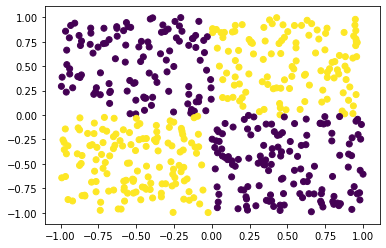

Test results:


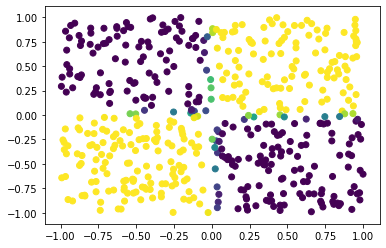

In [3]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

learning_rate = 0.001


# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0

L2_lambda = 0.0

batch_size = 10

# control amount of training data
nTrainPoints = 10
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 500

DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out = nn.Linear(nLinear2, 1)    # output 

        self.non_linear1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.non_linear2 = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.out(x)
        out = self.non_linear2(x)

        return out

###############################################################################
def train(model, optimizer, criterion, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)     # "model()" invokes "model.forward()"
    outputs = outputs.view(-1)
    loss += criterion(outputs, targets)
  #   loss += criteria[0](output0.view(-1), targets0)
  #  loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss.backward()
        optimizer.step()

    return loss.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    #criterion = nn.BCEWithLogitsLoss(reduction='sum')
    criterion = nn.BCELoss(reduction='sum')


    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

###############################################################################
# train model 
###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss, nPoints = train(model, optimizer, criterion, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss += loss
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss, DevPoints = train(model, optimizer, criterion, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d\t train = %8d\t%8.4f\tdev = %8d\t%8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss / TrainPoints, DevPoints, DevLoss / DevPoints))

                TrainLoss = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'XOR.pth')

    return

###############################################################################
def func(x0, x1):
    l = len(x0)
    y = []
    for i in range(l):
        if x0[i]*x1[i]>0:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

###############################################################################
def create_data(data_spec):
    nPoints = data_spec
    rng = np.random.RandomState(0)
    x = 2*rng.rand(nPoints, 2)-1
    x0 = x[: , 0]
    x1 = x[: , 1]
    y = func(x0, x1)
    #y1 = func1(x)
    x = np.array([x0, x1]).T
    return [x, y]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    train_data  = create_data(nTrainPoints)
    dev_data    = create_data(nDevPoints)
    test_data   = create_data(nTestPoints)

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(2, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y = test_data
        out = model(torch.Tensor(x))
        #print(out0)
        out = out.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
   #     out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        BCE0 = (((y - out)**2).sum()) / len(y)
        print("binary cross entropy for test data =", BCE0)

     # show test data 
        plt.scatter(x[:,0], x[:,1], c=y)
        print("Test dataset:")
        plt.show()
    # show result  
        #out[out >= 0.5] =1
        #out[out < 0.5] = 0
        plt.scatter(x[:,0], x[:,1], c=out)
        print("Test results:")
        plt.show()

NN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (non_linear1): LeakyReLU(negative_slope=0.01)
  (non_linear2): Sigmoid()
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000	 train =     5000	  0.2999	dev =      101	  0.0908
epoch =     1    10003	 train =     5003	  0.0836	dev =      101	  0.0372
epoch =     2    15006	 train =     5003	  0.0637	dev =      101	  0.0306
epoch =     3    20009	 train =     5003	  0.0517	dev =      101	  0.0257
epoch =     4    25002	 train =     4993	  0.0463	dev =      101	  0.0143
epoch =     5    30005	 train =     5003	  0.0413	dev =      101	  0.0118
epoch =     6    35008	 train =     5003	  0.0371	dev =      101	  0.0197
epoch =     7    40001	 train =     4993	  0.0360	dev =      101	  0.0128
epoch =     8    45004	 train =     5003	  0.0323	dev =      101	  0.0124
epoch =     9    500

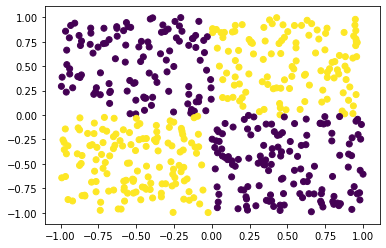

Test results:


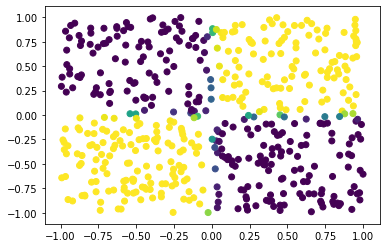

In [7]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

learning_rate = 0.001


# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0

L2_lambda = 0.0002

batch_size = 10

# control amount of training data
nTrainPoints = 10
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 500

DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out = nn.Linear(nLinear2, 1)    # output 

        self.non_linear1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.non_linear2 = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.out(x)
        out = self.non_linear2(x)

        return out

###############################################################################
def train(model, optimizer, criterion, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)     # "model()" invokes "model.forward()"
    outputs = outputs.view(-1)
    loss += criterion(outputs, targets)
  #   loss += criteria[0](output0.view(-1), targets0)
  #  loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss.backward()
        optimizer.step()

    return loss.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    #criterion = nn.BCEWithLogitsLoss(reduction='sum')
    criterion = nn.BCELoss(reduction='sum')


    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

###############################################################################
# train model 
###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss, nPoints = train(model, optimizer, criterion, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss += loss
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss, DevPoints = train(model, optimizer, criterion, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d\t train = %8d\t%8.4f\tdev = %8d\t%8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss / TrainPoints, DevPoints, DevLoss / DevPoints))

                TrainLoss = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'XOR.pth')

    return

###############################################################################
def func(x0, x1):
    l = len(x0)
    y = []
    for i in range(l):
        if x0[i]*x1[i]>0:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

###############################################################################
def create_data(data_spec):
    nPoints = data_spec
    rng = np.random.RandomState(0)
    x = 2*rng.rand(nPoints, 2)-1
    x0 = x[: , 0]
    x1 = x[: , 1]
    y = func(x0, x1)
    #y1 = func1(x)
    x = np.array([x0, x1]).T
    return [x, y]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    train_data  = create_data(nTrainPoints)
    dev_data    = create_data(nDevPoints)
    test_data   = create_data(nTestPoints)

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(2, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y = test_data
        out = model(torch.Tensor(x))
        #print(out0)
        out = out.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
   #     out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        BCE0 = (((y - out)**2).sum()) / len(y)
        print("binary cross entropy for test data =", BCE0)

     # show test data 
        plt.scatter(x[:,0], x[:,1], c=y)
        print("Test dataset:")
        plt.show()
    # show result  
        #out[out >= 0.5] =1
        #out[out < 0.5] = 0
        plt.scatter(x[:,0], x[:,1], c=out)
        print("Test results:")
        plt.show()